# Nesse notebook vou treinar a aplicação de IA/Machine learning usando o algoritmo de KNN e a base de dados Data.csv que tem dados sobre notas de alunos desde o fundamental até o ensino médio. Para então ver oq é possível inferir

## **Importing Libs**

In [37]:
# Bibliotecas para manipulação de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para criar nosso model de Machine Learning(ML)
from sklearn import preprocessing, model_selection, neighbors
from sklearn.preprocessing import StandardScaler

# Biblioteca para plotar nosso modelo
from mlxtend.plotting import plot_decision_regions

## **Análise Básica do Dataset**

In [38]:
df = pd.read_csv('Data.csv')
df.drop(['sl_no'], 1, inplace=True)

In [39]:
df.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


In [40]:
df.info()
# Obs: Importante saber os tipos das variáveis dentro da base de dados pra poder 
#ver quais colunas estão os dados numéricos que para este caso são os que são necessários

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          215 non-null    object 
 1   ssc_p           215 non-null    float64
 2   ssc_b           215 non-null    object 
 3   hsc_p           215 non-null    float64
 4   hsc_b           215 non-null    object 
 5   hsc_s           215 non-null    object 
 6   degree_p        215 non-null    float64
 7   degree_t        215 non-null    object 
 8   workex          215 non-null    object 
 9   etest_p         215 non-null    float64
 10  specialisation  215 non-null    object 
 11  mba_p           215 non-null    float64
 12  status          215 non-null    object 
 13  salary          148 non-null    float64
dtypes: float64(6), object(8)
memory usage: 23.6+ KB


In [41]:
df.describe() #descreve apenas as colunas que tem valores numéricos

,ssc_p,hsc_p,degree_p,etest_p,mba_p,salary
count,215.000000,215.000000,215.000000,215.000000,215.000000,148.000000
mean,67.303395,66.333163,66.370186,72.100558,62.278186,288655.405405
std,10.827205,10.897509,7.358743,13.275956,5.833385,93457.452420
min,40.890000,37.000000,50.000000,50.000000,51.210000,200000.000000
25%,60.600000,60.900000,61.000000,60.000000,57.945000,240000.000000
50%,67.000000,65.000000,66.000000,71.000000,62.000000,265000.000000
75%,75.700000,73.000000,72.000000,83.500000,66.255000,300000.000000
max,89.400000,97.700000,91.000000,98.000000,77.890000,940000.000000


In [42]:
# Incluindo agora apenas as colunas com valores do tipo 'object'
df.describe(include=['object'])

,gender,ssc_b,hsc_b,hsc_s,degree_t,workex,specialisation,status
count,215,215,215,215,215,215,215,215
unique,2,2,2,3,3,2,2,2
top,M,Central,Others,Commerce,Comm&Mgmt,No,Mkt&Fin,Placed
freq,139,116,131,113,145,141,120,148


## **Tratamento de dados**

filtrando os dados: transformando as variáveis strings em valores numéricos para poder aplicar o kNN

In [43]:
# Primeiramente filtrando os valores Others da coluna degree_t (por acabar sendo um dado outlier)
df = df[df['degree_t'] != 'Others']

In [44]:
# Inserindo 0 para os que n possuem salário, ou seja, estão como NaN
df['salary'].fillna(0, inplace=True)

In [45]:
df['salary'].describe()

count       204.000000
mean     202544.117647
std      154464.984840
min           0.000000
25%           0.000000
50%      240000.000000
75%      285500.000000
max      940000.000000
Name: salary, dtype: float64

Pode-se inferir que a mediana do salário das pessoas é 240k, e a partir dela serão divido os gps de quem ganha mais e quem ganha menos doq o valor da mediana

In [46]:
#transformando assim os valores da base de acordo com essa mediana, para que 0 seja quem tem o salario menor que a mediana e 1 para quem tiver um maior
df.loc[df['salary'] < 240000.00, 'salary'] = 0
df.loc[df['salary'] >= 240000.00, 'salary'] = 1

In [47]:
df['salary'].unique()

array([1., 0.])

Para melhorar a precisão a acurácia do modelo será utilizada a função do pandas a seguir que cria novas colunas para cada valor que temos em uma determinada coluna querendo dizer sim(1) ou não(0) para esse valor.

In [48]:
df_dummy = pd.get_dummies(df)
df_dummy.head()

,ssc_p,hsc_p,degree_p,etest_p,mba_p,salary,gender_F,gender_M,ssc_b_Central,ssc_b_Others,hsc_b_Central,hsc_b_Others,hsc_s_Arts,hsc_s_Commerce,hsc_s_Science,degree_t_Comm&Mgmt,degree_t_Sci&Tech,workex_No,workex_Yes,specialisation_Mkt&Fin,specialisation_Mkt&HR,status_Not Placed,status_Placed
0,67.00,91.00,58.00,55.0,58.80,1.0,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,0,1
1,79.33,78.33,77.48,86.5,66.28,0.0,0,1,1,0,0,1,0,0,1,0,1,0,1,1,0,0,1
2,65.00,68.00,64.00,75.0,57.80,1.0,0,1,1,0,1,0,1,0,0,1,0,1,0,1,0,0,1
3,56.00,52.00,52.00,66.0,59.43,0.0,0,1,1,0,1,0,0,0,1,0,1,1,0,0,1,1,0
4,85.80,73.60,73.30,96.8,55.50,1.0,0,1,1,0,1,0,0,1,0,1,0,1,0,1,0,0,1


## **Matriz de correlação**

Ánalise das variáveis que mais explicam os indivíduos terem o valor do salário abaixo ou acima da mediana

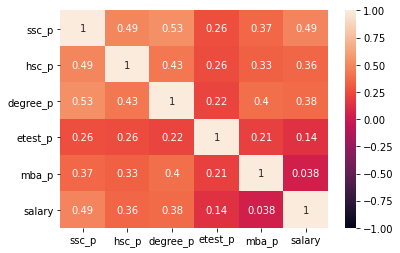

In [49]:
sns.heatmap(df.corr(), annot=True, vmin=-1,vmax=1)
plt.show()

É possível ver que a coluna salary tem maior correlação com as colunas ssc_p e hsc_p que são notas no fundamental e ensino médio de uma matéria.

Lembrando que correlação n implica em causalidade

## **Análise gráfica**

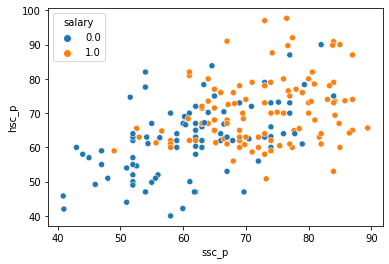

In [50]:
sns.scatterplot(data=df, x='ssc_p', y='hsc_p', hue='salary')
plt.show()

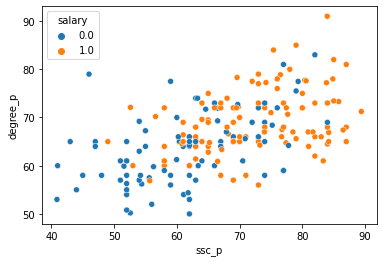

In [51]:
sns.scatterplot(data=df, x='ssc_p', y='degree_p', hue='salary')
plt.show()

## **Aplicando modelo de Machine Learning: KNN**

Antes de aplicar o modelo é importante decidir que características serão analisadas e qual a coluna que queremos prever, ou seja, quais as colunas são as features(X) e qual é a target(y)

In [53]:
# Colunas das Features são todas menos a coluna do salário
# Note que deve ser um array em numpy
X = np.array(df_dummy.drop(['salary'], 1))

# Coluna do target, nesse caso, salary
y = np.array(df_dummy['salary'])

Separando o dataset em treino e teste com a função a seguir, na proporção de 80 treino e 20% teste

In [54]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size= 0.2, random_state=0)

Como o KNN depende muito das distâncias entre os pontos, é bom normalizar os valores para aumentar a precisão.
E para isso será utilizada a seguinte função

In [55]:
sc_X = StandardScaler()
X_train =  sc_X.fit_transform(X_train)
X_test =  sc_X.fit_transform(X_test)

Agora tudo certo para definir o modelo de ML usando o KNN.
Usando a função a seguir para executar o códido do KNN

In [65]:
#Algoritmo do KNN
clf = neighbors.KNeighborsClassifier(n_neighbors=19, metric='euclidean')

Falta agora treinar


In [66]:
#Função de treino
clf.fit( X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=19, p=2,
                     weights='uniform')

Algoritmo treinado, agora vamos testar !!

In [67]:
# Função de teste
accuracy = clf.score(X_test,y_test)
accuracy

0.9024390243902439

## **Visualizando Fronteira**

Só pra ver melhor os gráficos plotados anteriormente. (usando apenas duas colunas,mas n são as unicas q influenciaram no resultado)

In [74]:
def knn_comparison(data, k):
  x = data[['ssc_p','hsc_p']].values
  y = data['salary'].astype(int).values
  knn = neighbors.KNeighborsClassifier(n_neighbors=k)
  knn.fit(x, y)
  plt.xlabel('ssc_p')
  plt.ylabel('hsc_p')
  plt.title('K='+ str(k))
  plot_decision_regions(x, y, clf=knn)
  plt.show()

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


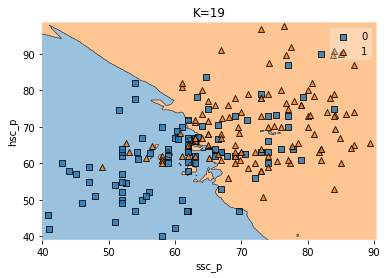

In [77]:
knn_comparison(data=df_dummy, k=19)

## **Como usar na prática?**

Para facilitar o entendimento e a visualização dps

In [84]:
#primeira linha da base de dados
df_dummy.head(1).T

,0
ssc_p,67.0
hsc_p,91.0
degree_p,58.0
etest_p,55.0
mba_p,58.8
salary,1.0
gender_F,0.0
gender_M,1.0
ssc_b_Central,0.0
ssc_b_Others,1.0


Para caso vc ter todas as informalções necessárias menos o valor do salario, então pode ser feito da seguinte maneira.

In [82]:
# Dados da pessoa que queremos prever
exemplo = np.array([45,45,60,60,50,1,0,1,0,0,0,0,1,0,1,0,0,1,1,0,0,0])

# Alterando seu formato
exemplo = exemplo.reshape(1, -1)

# Normalizar os números, igual anteriormente
exemplo = sc_X.transform(exemplo)

# Prevendo sua faixa de renda
predicao = clf.predict(exemplo)

print(predicao) # 0 a renda é menor q mediana e 1 é maior ou igual a mediana

[0.]


In [2]:
a = 'andre'
a

'andre'

In [3]:
b = 23
b

23

In [4]:
str(b)

'23'